# Peak Comparisons
Comparing peak locations with mean locations and zero

## Setup

In [26]:
import torch
import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from taker import Model
from taker.activations import get_midlayer_activations

In [27]:
def get_mean_offsets(activations):
    # Check if the activations tensor is of type torch.float16
    if activations.dtype == torch.float16:
        # Convert to torch.float32 for mode calculation
        activations_float32 = activations.float()
    else:
        # Use the original tensor if it's already in a supported data type
        activations_float32 = activations

    # Compute the mode across the last dimension for each neuron in every layer
    #mode_values_float32, _ = torch.mode(activations_float32, dim=-1)
    mode_values_float32 = torch.mean(activations_float32, dim=-1)
    
    # If the original tensor was torch.float16, convert the result back to torch.float16
    if activations.dtype == torch.float16:
        mode_values = mode_values_float32.half()
    else:
        mode_values = mode_values_float32
    
    # The mode_values tensor will have shape [layers, neurons], which is already 2D
    # and matches the requirement of returning a 2D tensor of mode values.
    
    return mode_values

def get_bucket_peaks(activations):
    # Check if the activations tensor is of type torch.float16
    if activations.dtype == torch.float16:
        # Convert to torch.float32 for histogram calculation
        activations_float32 = activations.float()
    else:
        # Use the original tensor if it's already in a supported data type
        activations_float32 = activations

    # Prepare for histogram computation
    #min_val = activations_float32.min()
    #max_val = activations_float32.max()
    bins = 100

    # Initialize an empty tensor to hold the peak values
    peak_values_float32 = torch.empty(activations_float32.size()[:-1], device=activations_float32.device, dtype=torch.float32)
    
    # Compute the histogram and find the peak for each neuron in every layer
    for i in range(activations_float32.size()[0]):  # Assuming the first dimension is layers
        for j in range(activations_float32.size()[1]):  # Assuming the second dimension is neurons
            min_val = activations_float32[i, j].min()
            max_val = activations_float32[i, j].max()

            hist = torch.histc(activations_float32[i, j], bins=bins, min=min_val, max=max_val)
            peak_bin = hist.argmax()
            # Compute the center value of the peak bin
            bin_width = (max_val - min_val) / bins
            peak_value = min_val + bin_width * (peak_bin.float() + 0.5)
            peak_values_float32[i, j] = peak_value

    # If the original tensor was torch.float16, convert the result back to torch.float16
    if activations.dtype == torch.float16:
        peak_values = peak_values_float32.half()
    else:
        peak_values = peak_values_float32

    return peak_values

def get_kde_peaks(activations, bandwidth=0.1):
    layers, neurons, _ = activations.shape  # Assuming activations is a 3D tensor of shape [layers, neurons, activations]

    # Initialize an empty tensor for main peak values with shape [layers, neurons]
    main_peak_values = torch.empty((layers, neurons), dtype=torch.float32)

    # Ensure activations are in float32 for KDE
    if activations.dtype == torch.float16:
        activations_float32 = activations.float()
    else:
        activations_float32 = activations

    # Iterate over each layer and neuron to compute the main peak value
    for layer in range(layers):
        print(f"Calculating KDE for layer {layer+1} of {layers}")
        for neuron in range(neurons):
            # Convert activations to numpy for KDE computation
            activations_np = activations_float32[layer, neuron].cpu().numpy().flatten()

            # Perform Kernel Density Estimation
            kde = stats.gaussian_kde(activations_np, bw_method=bandwidth)
            
            # Evaluate the KDE on a fine grid to find the peak
            grid = np.linspace(activations_np.min(), activations_np.max(), 1000)
            kde_values = kde.evaluate(grid)
            
            # Identify the main peak as the grid value with the highest KDE estimate
            main_peak_value = grid[np.argmax(kde_values)]

            # Store the main peak value
            main_peak_values[layer, neuron] = main_peak_value

    # No need to adjust activations here; just return the 2D tensor of main peak values
    return main_peak_values

def get_mode_offsets(activations):
    # Check if the activations tensor is of type torch.float16
    if activations.dtype == torch.float16:
        # Convert to torch.float32 for mode calculation
        activations_float32 = activations.float()
    else:
        # Use the original tensor if it's already in a supported data type
        activations_float32 = activations

    # Compute the mode across the last dimension for each neuron in every layer
    mode_values_float32, _ = torch.mode(activations_float32, dim=-1)
    #mode_values_float32 = torch.mean(activations_float32, dim=-1)
    
    # If the original tensor was torch.float16, convert the result back to torch.float16
    if activations.dtype == torch.float16:
        mode_values = mode_values_float32.half()
    else:
        mode_values = mode_values_float32
    
    # The mode_values tensor will have shape [layers, neurons], which is already 2D
    # and matches the requirement of returning a 2D tensor of mode values.
    
    #flip the sign on everything since we are doing addition in the offset mask
    #return mode_values * -1
    return mode_values

## Get Data

In [28]:
#opt = Model('facebook/opt-125m', limit=1000)
#dataset = 'pile'

opt = Model('google/vit-base-patch16-224', limit=1000, dtype='fp32')
dataset = 'imagenet-1k-birdless'

/home/ubuntu/aisc-peak-activations/.venv/lib/python3.10/site-packages/taker/model.py:147: UserWarning: Model google/vit-base-patch16-224 not tested.
  warnings.warn( f"Model {model_repo} not tested." )


- Loaded google/vit-base-patch16-224
 - Registered 12 Attention Layers


In [29]:

data = get_midlayer_activations( opt, dataset, 1e4, collect_ff=False, collect_attn=True )
# [token, layer, neuron] -> [layer, neuron, token]
#ff_activations   = data.raw["ff"].permute( (1,2,0) )
# [token, layer, attention head, attention neuron] -> [layer, attention head, attention neuron, token]
attn_activations = data.raw["attn"].permute( (1,2,3,0) ).reshape( (opt.cfg.n_layers, opt.cfg.d_model, -1) )


/home/ubuntu/aisc-peak-activations/.venv/lib/python3.10/site-packages/datasets/load.py:1454: FutureWarning: The repository for imagenet-1k contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/imagenet-1k
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
 47%|████▋     | 4728/10000.0 [00:07<00:07, 733.27it/s]

Could not process an input of imagenet-1k-birdless


 97%|█████████▋| 9653/10000.0 [00:15<00:00, 725.09it/s]

Could not process an input of imagenet-1k-birdless


10047it [00:15, 638.16it/s]                            


In [30]:

def skewness(tensor):
    # Calculate the mean along the last dimension with keepdim=True to maintain dimensionality for broadcasting
    mean = torch.mean(tensor, dim=-1, keepdim=True)
    
    # Calculate the standard deviation along the last dimension, also keeping dimensions
    std_dev = torch.std(tensor, dim=-1, keepdim=True)
    
    # Prevent division by zero by setting zero std_dev to 1 (or a small number)
    std_dev[std_dev == 0] = 1
    
    # Calculate the third moment (central) along the last dimension, keeping dimensions for broadcasting
    third_moment = torch.mean((tensor - mean) ** 3, dim=-1, keepdim=True)
    
    # Calculate the skewness with compatible dimensions for broadcasting
    skew = third_moment / (std_dev ** 3)
    
    # Removing the last dimension (now redundant due to keepdim=True in calculations)
    skew = skew.squeeze(-1)
    return skew

skewnesses = skewness(attn_activations)

print(skewnesses[0][0])

#get skewness of attn activations[0, 0] using stats.skew
skewness_check = stats.skew(attn_activations[0, 0].cpu().numpy().flatten())
print(skewness_check) 

#pring most skewed neuron value
print(torch.max(skewnesses))

#print mean skewedness
print(torch.mean(skewnesses))

#print mean absolute skewedness (is this a good metric?)
print(torch.mean(torch.abs(skewnesses)))


tensor(0.1221)
0.12210375653542821
tensor(3.0458)
tensor(-0.0046)
tensor(0.3775)


In [31]:

means = get_mean_offsets(attn_activations)
peaks = get_bucket_peaks(attn_activations)

#get the distance between the mean and the peak
mean_peak_diff = torch.abs(means - peaks)

#distance of means from 0
peak_0_diff = torch.abs(peaks)

#distance of peaks from 0
mean_0_diff = torch.abs(means)

In [32]:
#print sums of all of the differences
print(f"mean_peak_diff: {mean_peak_diff.sum()}")
print(f"peak_0_diff: {peak_0_diff.sum()}")
print(f"mean_0_diff: {mean_0_diff.sum()}")

#print peak avg value
print(f"peak avg: {peaks.mean()}")
#print mean avg value
print(f"mean avg: {means.mean()}")

mean_peak_diff: 754.652587890625
peak_0_diff: 764.1264038085938
mean_0_diff: 551.6011962890625
peak avg: -0.00044539105147123337
mean avg: -0.0009681335068307817


In [33]:
#TODO: how often is the peak at 0 (or really close)
def num_peaks_at_zero(peaks, tolerance=0.01):
    # Count how many numbers are within the tolerance of the target value
    close_to_target = torch.abs(peaks) <= tolerance
    return close_to_target.sum()

print(f"peaks at 0: {num_peaks_at_zero(peaks)}")
print(f"means at 0: {num_peaks_at_zero(means)}")

#print size of peaks
print(f"peaks size: {peaks.size()}")

# print 100 peaks
print(peaks[3, :100])

#FIXME: are all of the peaks are basically the same because of how we are doing the bucketing?


peaks at 0: 1012
means at 0: 1356
peaks size: torch.Size([12, 768])
tensor([ 0.1746, -0.0068,  0.0297, -0.2471,  0.0806,  0.1033, -0.1238,  0.0777,
         0.0365,  0.0660,  0.1614, -0.0096, -0.0413,  0.0108,  0.2266, -0.0655,
        -0.0975,  0.0937, -0.1021,  0.1383,  0.0276, -0.1914, -0.0919,  0.0072,
         0.0365,  0.0072, -0.0534,  0.0294,  0.1385,  0.1410, -0.0522, -0.0013,
        -0.0469, -0.0071, -0.0331, -0.0415, -0.2043,  0.0675, -0.0352,  0.0602,
         0.0223, -0.0164, -0.1235, -0.1846,  0.0583,  0.1295,  0.0028,  0.0572,
        -0.0106,  0.0671, -0.1872, -0.0329, -0.0031, -0.1230,  0.0419,  0.0078,
        -0.0104, -0.0392,  0.0139, -0.0246, -0.0527,  0.0250, -0.0672, -0.0425,
        -0.0603,  0.0647,  0.0259,  0.0410,  0.0047, -0.0191,  0.1048, -0.0167,
         0.0412, -0.0563,  0.0232,  0.0730, -0.0404,  0.0484,  0.0313,  0.0711,
         0.1234,  0.0061, -0.0894,  0.0446,  0.0964,  0.0514, -0.0224,  0.0815,
         0.1489, -0.0406,  0.0151,  0.0116,  0.0841,

## Plot

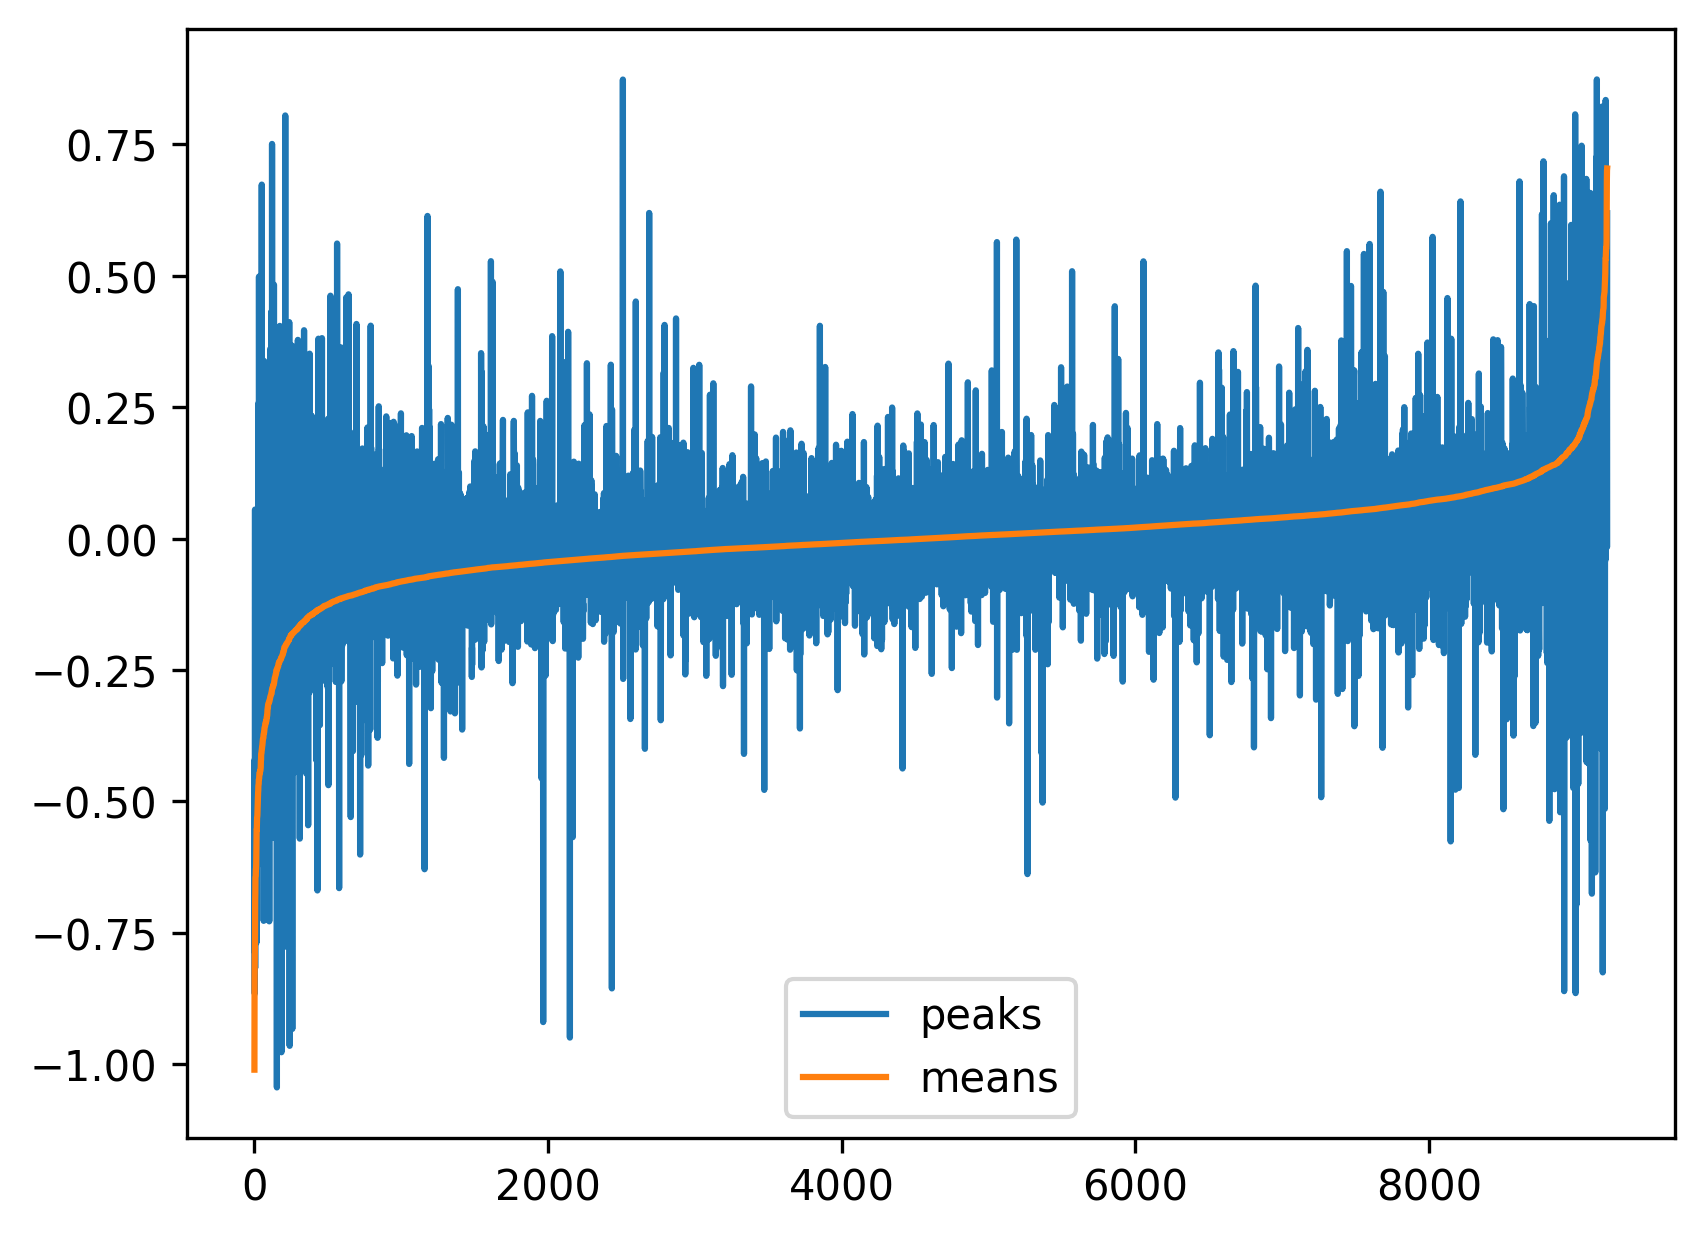

In [34]:
#plot flattened peaks vs means on line graph
peaks_flt = peaks.flatten()
means_flt = means.flatten()

# sort peaks and means
#peaks, _ = torch.sort(peaks)
#means, _ = torch.sort(means)

# argsort means and plot based on that
means_graph = means_flt[torch.argsort(means_flt)]
peaks_graph = peaks_flt[torch.argsort(means_flt)]

plt.plot(peaks_graph.cpu(), label='peaks')
plt.plot(means_graph.cpu(), label='means')
plt.legend()
plt.show()


